<a href="https://colab.research.google.com/github/williamedwardhahn/ComplexSystems/blob/main/Complex_Systems_Lab_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import pylab
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.utils

In [ ]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-yesvxe2m
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-yesvxe2m
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp36-none-any.whl size=7325 sha256=84e2b298b0566ddff6218c256b03f9be1cbdf63fc61c1c8afcb52ba0414403c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-pltps0xe/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [ ]:
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

In [ ]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()

In [ ]:
def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))

In [ ]:
#MNIST
train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

#KMNIST
#train_set = datasets.KMNIST('./data', train=True, download=True)
#test_set = datasets.KMNIST('./data', train=False, download=True)

#Fashion MNIST
# train_set = datasets.FashionMNIST('./data', train=True, download=True)
# test_set = datasets.FashionMNIST('./data', train=False, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
X = train_set.data.numpy()
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()
X = X[:,None,:,:]/255
X_test = X_test[:,None,:,:]/255
X = (X - 0.5)/0.5
X_test = (X_test - 0.5)/0.5

In [ ]:
X.shape,Y.shape,X_test.shape,Y_test.shape

((60000, 1, 28, 28), (60000,), (10000, 1, 28, 28), (10000,))

In [ ]:
###################################################

In [ ]:
def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=torch.device('cuda'))

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=torch.device('cuda'))

In [ ]:
X = GPU_data(X)
X_test = GPU_data(X_test)

Y = GPU_data(Y)
Y_test = GPU_data(Y_test)

In [ ]:
X = torch.squeeze(X)
X_test = torch.squeeze(X_test)

In [ ]:
def get_batch(mode):
    b = bs
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:,:]
        y = Y_test[r:r+b]
    return x,y

In [ ]:
x,y = get_batch('train')

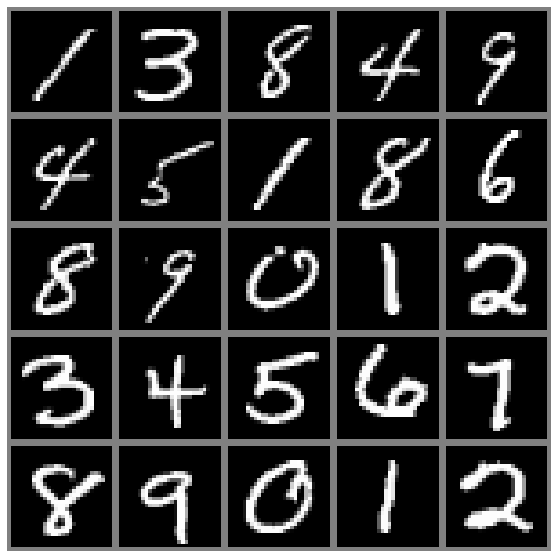

In [ ]:
montage_plot(x[0:25,:,:].detach().cpu().numpy())

In [ ]:
x,y = get_batch('train')

In [ ]:
def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s

In [ ]:
def cross_entropy(outputs, labels):            
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]  

In [ ]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [ ]:
def acc(out,y):
    with torch.no_grad():
        return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]

In [ ]:
def gradient_step(w):

    for j in range(len(w)): 

            w[j].data = w[j].data - c.h*w[j].grad.data
            
            w[j].grad.data.zero_()

In [ ]:
def make_plots():
    
    acc_train = acc(model(x),y)
    
    xt,yt = get_batch('test')

    acc_test = acc(model(xt),yt)

    wb.log({"acc_train": acc_train, "acc_test": acc_test})

In [ ]:
X = GPU_data(X)
Y = GPU_data(Y)
X_test = GPU_data(X_test)
Y_test = GPU_data(Y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [ ]:
def relu(x):
    return x * (x > 0)

In [ ]:
%%html
<div class="mxgraph" style="max-width:100%;border:1px solid transparent;" data-mxgraph="{&quot;highlight&quot;:&quot;#0000ff&quot;,&quot;nav&quot;:true,&quot;resize&quot;:true,&quot;toolbar&quot;:&quot;zoom layers lightbox&quot;,&quot;edit&quot;:&quot;_blank&quot;,&quot;xml&quot;:&quot;&lt;mxfile host=\&quot;app.diagrams.net\&quot; modified=\&quot;2021-01-22T06:01:08.798Z\&quot; agent=\&quot;5.0 (X11)\&quot; etag=\&quot;W73EOSnNVc62GM2_w6yO\&quot; version=\&quot;14.2.6\&quot; type=\&quot;device\&quot;&gt;&lt;diagram id=\&quot;144d3d8f-15dc-1554-6705-1ed6627c971d\&quot; name=\&quot;Page-1\&quot;&gt;7Vzbjts2EP2aBdqHBLrwIj0mm2xaoJegCdDkqaAlylIri4ZMx95+fSmLtC60N9xdiZa38gKJNSJpUnN4ZjhD6sa/Xe0/lGSd/spimt94Try/8d/deJ4HA1/8V0nuawmAoZQsyyyuZW4j+JT9S6XQkdJtFtNNpyBnLOfZuiuMWFHQiHdkpCzZrlssYXn3V9dkKX/RaQSfIpJTrdifWczTWhrAVumfaLZM1S+7jryzIqqwFGxSErNdS+S/v/FvS8Z4/W21v6V59fTUc6nr3Z25e+xYSQtuUsHzPReFSRKgGMIkCF8B2bFvJN/K0cqe8ns1/JJti5hWLbg3/ttdmnH6aU2i6u5OaFzIUr7K5e3jCB1xsczJZiO/b3jJ/qG3LGfloVnfER+Ij3fUkwVCkmR53ip5d/hUclbwO7LK8gpJn7OVAIXn/EZ34t8/2IoUsohEkIvldasp8K76E/KYbNLjmA6V5IBPPFMp+kZLTvctkXzGHyhbUV7eiyIK815YV5GIf+WGCgG7BkChajhtgQdiKIErQbs8tt7oVXyRqjVVs6tplcYC4/KSlTxlS1aQ/H0jfdvo3enqmO4z/qX1/WtV5DWsrgrR0y+yxuGid+8jLYXaOC2PqCAlf1PNUSEoWEGV7C6rRifbiVWJqAJUFtVCWaTqxd+U83updrLlTIiaMf3C2Fqh8xQIgzcaCP1hwWaGrw3blhE9p0E5L8WzWVJ+phCWhSrdPojTkuaEZ9+6/DYs4jyNWD6TIrVFLvXntF7HJ5eh+SRUlvDIJwgCjU/wCTpBzhi69S/PJjNxmBIHMCAOYYcnQxxAI479D/xHW8QR43DhOCbEkSQURdG0icMFfeLAyhVoEQeCtogDarpNf+CvXGvaDRH2CTLRLnVjSPG1aReB8ILaRZp2I6vaRYeP0dyF1d+1aRco/+4i2g0sGX1x1V8lzI7AEI5AaOAIKLd9OEfgUFU8fXLfKrBmWcE3rZY/VoIG+4GC9RH70Pfb8DWogTzQA3zdiwb+x+E8cUaEGt9pU6Sa7lkkEEQWNP/INhnPmND7uwXjnK2EYlWBN3m2rG5w1qe/Dqy8mhDXVfOr/bIKuL1OcraLUoH415vtapUVy7+SbRHVP9SbgWe59AoXRRiDPkYg0vgRnOBHMEaIRUUD7S2KmsuvbWqcQyxPJEioYstXEmJR/W3xz+9bvt5WrPiBcGrL7Qq8hW/mdgmXOojBtGkF+EGPVoITSyZXxXNH97ugHki7TUkh0GdXyzFaIGjmXCeJN/WFsa5lDPSImkUt+5qWfy7sT2UUBXSRGE1lQoPk6pSMgO4hWFSyHtq6YwdbY1fLiwACaBbjCiJ6fVMZnoiCWNQytO0Izovipy+KoYHPN6HoONRjbBralgJM66dPtOM+CrJQLTqnhytr+a7Xp9lQz3Yr5u0sxLwxHhHWHSbCbXHrpBOP5+H0fba9iCptxRxnKh1g+YxNqNSdDpWGM7heGLimE5tB1qOBM7hGBpc/HXBNYDffDK5BwQWmAy493qihzW5Wq9LKC85jIdDPXAKVy7xEHgtNYHPfnMd6VkwDGTCOmuZTYBxgG3Fz5nRgG2eyx3RKiNP3Ic42zq6NQwG+oI1DM+NcOeN4JowDp8M4+LKIc2fEPRdx/pUhbhL7dWfeGxaFyCRfqdLfF97Ei0PcN/po5C25WD/OHFk8PPTCDiC4oRaZwPomKWsnEJCthM0jGG22q89mNBNPbrKMBuTe0PEYzVasfz52Mw6+sQm+8XSSS6q/c2zElpl1FLu1tqleMDiC9a3IqUUf6oUd0dV9qFOvbrDmQ+FRYu2OZk465qEh/7aFcLsWQtqQxjw4zzEPD6FoOLR0XyJ0Bp1nUTSwM6N5K77bR54Lum3UNklWa1CltXTioHm/qdoGak0N4gKNsqFax2xHm5cG8ENLyQHp7syq9HKY1c68+3gozGpNjYnZUTIM0+PZh16XYodnj69hmQ7PYgcNhVmtqTExaylHcZ5nL7CO/J/yrOtDPZThPxG1R1f1fFtjwtZSomNSsLXj307OpRWw1Y50esPBVmtrRNh647gIc2TPDNq2IPzoN9+4/WDQ49988/gaQEaSToaxjfpothzUJ+GJHFM/qnVmQn9/EorL5tXKdfHmDdX++/8A&lt;/diagram&gt;&lt;/mxfile&gt;&quot;}"></div>
<script type="text/javascript" src="https://viewer.diagrams.net/js/viewer-static.min.js"></script>

In [ ]:
def LSTM(x, h_t, c_t):

    bs, seq_sz, _ = x.size()

    hidden_seq = torch.zeros((bs,seq_sz,hidden_sz)).cuda()

    for t in range(seq_sz):

        x_t = x[:, t, :]

        i_t = torch.sigmoid(x_t @ w[0] + h_t @ w[1]  + w[2])
        f_t = torch.sigmoid(x_t @ w[3] + h_t @ w[4]  + w[5])
        g_t =    torch.tanh(x_t @ w[6] + h_t @ w[7]  + w[8])
        o_t = torch.sigmoid(x_t @ w[9] + h_t @ w[10] + w[11])
        
        c_t = f_t * c_t + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        hidden_seq[:,t,:] = h_t.unsqueeze(0)

    return hidden_seq, h_t, c_t   

In [ ]:
def model(x):

    out,h,c  = LSTM(x,h_t,c_t)
    # out,h,c  = LSTM(x,h,c)
    out = out[:, -1, :]
    out = relu(matmul(out,w[12]))

    return out

In [ ]:
wb.init(project="Simple LSTM");
c = wb.config

c.h = 0.001
c.epochs = 5000
bs = 256

sequence_length = 28
input_sz = 28
hidden_sz = 128

U_i = GPU(randn_trunc((input_sz, hidden_sz)))
V_i = GPU(randn_trunc((hidden_sz, hidden_sz)))
b_i = GPU(randn_trunc((hidden_sz)))

U_f = GPU(randn_trunc((input_sz, hidden_sz)))
V_f = GPU(randn_trunc((hidden_sz, hidden_sz)))
b_f = GPU(randn_trunc((hidden_sz)))

U_c = GPU(randn_trunc((input_sz, hidden_sz)))
V_c = GPU(randn_trunc((hidden_sz, hidden_sz)))
b_c = GPU(randn_trunc((hidden_sz)))

U_o = GPU(randn_trunc((input_sz, hidden_sz)))
V_o = GPU(randn_trunc((hidden_sz, hidden_sz)))
b_o = GPU(randn_trunc((hidden_sz)))

h_t = GPU(torch.zeros(bs, hidden_sz))
c_t = GPU(torch.zeros(bs, hidden_sz))

w_fc = GPU(randn_trunc((hidden_sz, 10)))

w = [U_i,V_i,b_i, U_f,V_f,b_f, U_c,V_c,b_c, U_o,V_o,b_o, w_fc]

optimizer = torch.optim.Adam(w, lr=c.h)  

for i in range(c.epochs):

    x,y = get_batch('train')

    loss = cross_entropy(softmax(model(x)),y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if (i+1) % 1 == 0:

        make_plots()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
